In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from dataImporter import *
from dataProcesser import *
from events import sim_events, list_of_params, ic_params
from functions import perform_chisq
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
np.set_printoptions(linewidth=200)

IC_observed_full = np.array(get_IC_data().T)
E_rate, z_rate = get_flux_factor()
flux_E_factors_full, flux_z_factors_full = bin_flux_factors(E_rate,z_rate)
EFrom,ETo,zFrom,zTo = 3,13,0,20
z_bins = np.arange(zFrom,zTo)
E_bins, z_bins_T = np.arange(EFrom,ETo), np.arange(zFrom,zTo)[:,None]
n_Ebins, n_zbins = len(E_bins), len(z_bins)
flux_E_factors = flux_E_factors_full[E_bins]
flux_z_factors = flux_z_factors_full[z_bins]
flux_factors = np.outer(flux_E_factors, flux_z_factors)
IC_observed = IC_observed_full[E_bins,z_bins_T].T
#IC_observed_2017 = np.array(pd.read_csv('./pre_computed/IC_observed_2017.csv', header=None))

In [3]:
giunti_contour_cl90 = pd.read_csv('./data/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./data/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./data/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./data/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')

E_ratios_full = pd.read_csv('./data/E_ratios.csv', header=None, names=['Ereco', 'Eratio']).Eratio.values
z_ratios_full = pd.read_csv('./data/z_ratios.csv', header=None, names=['zreco', 'zratio']).zratio.values
IC_per_z_full = np.array(np.sum(IC_observed_full, axis=0))
IC_per_E_full = np.array(np.sum(IC_observed_full, axis=1))
MC_per_E_full = (IC_per_E_full/E_ratios_full)
MC_per_z_full = (IC_per_z_full/z_ratios_full)

MC_ratios_full = np.outer(E_ratios_full, z_ratios_full)
IC_MC_full = IC_observed_full / MC_ratios_full
IC_MC = IC_MC_full[EFrom:ETo+1,z_bins]
#IC_MC_2017 = np.load('./pre_computed/IC_MC.npy')[E_bins,z_bins_T].T #Dont use this

In [19]:
plt.plot(IC_contour_cl99.s24, IC_contour_cl99.dm41)
#plt.fill_betweenx(x1=IC_contour_cl99.s24*0.7, x2=IC_contour_cl99.s24*1.3, y=IC_contour_cl99.dm41)
plt.xscale('log')
plt.yscale('log')

In [17]:
dm41_range = np.logspace(-1,1,10)
s24_range = np.logspace(-2,0,10)
arr = np.array([(s,d) for s in s24_range for d in dm41_range if s < 0.1 and d > 2 or s > 0.2 and d < 0.8])
print(len(arr))
#for i,item in enumerate(arr):
#(arr[0] < 0.1 and arr[1] > 2) or (arr[0] > 0.2 and arr[1] <0.8)


40


In [12]:
s_mesh

array([[0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ],
       [0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ],
       [0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ],
       [0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ],
       [0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ],
       [0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ],
       [0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ],
       [0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637, 0.12915497, 0.21544347, 0.359

In [4]:

Ereco_full = 500*10**np.linspace(0.0,1.3,14)
Ereco_full_midpoints = Ereco_full[0:-1] +np.diff(Ereco_full)/2 #For scatter plot

Ereco = Ereco_full[EFrom:ETo+1]
Ereco_midpoints= Ereco_full_midpoints[3:14]

zreco_full = np.linspace(-1,0,21)
zreco_full_midpoints = zreco_full[0:-1] +np.diff(zreco_full)/2 #For scatter plot

zreco = zreco_full[zFrom:zTo+1]
zreco_midpoints = zreco_full_midpoints[z_bins]


In [5]:
def to_hist(arr):
    return arr.tolist() + [arr[-1]]


def count_plots(H1,H0):
    IC_per_z = np.sum(IC_observed, axis=0)
    IC_per_E = np.sum(IC_observed, axis=1)

    IC_rate_z = IC_per_z /np.sum(H0, axis= 0)
    IC_rate_E = IC_per_E /np.sum(H0, axis= 1)

    H1_per_z_hist = to_hist(np.sum(H1, axis= 0))
    H1_per_E_hist = to_hist(np.sum(H1, axis= 1))
    H0_per_z_hist = to_hist(np.sum(H0, axis= 0))
    H0_per_E_hist = to_hist(np.sum(H0, axis= 1))

    H1_rate_z_hist = to_hist(np.sum(H1, axis= 0) / np.sum(H0, axis= 0))
    H1_rate_E_hist = to_hist(np.sum(H1, axis= 1) / np.sum(H0, axis= 1))
    H0_rate_z_hist = to_hist(np.sum(H0, axis= 0) / np.sum(H0, axis= 0))
    H0_rate_E_hist = to_hist(np.sum(H0, axis= 1) / np.sum(H0, axis= 1))

    fig, ax = plt.subplots(2,2, sharex='col', squeeze=True,gridspec_kw={'width_ratios': [3, 3], 'height_ratios':[3,1]}, figsize=(12,8))
    ax = ax.flatten()

    ax[0].scatter(Ereco_midpoints, IC_per_E, label='IC data', s=10, color='black', zorder=10)
    ax[0].step(Ereco, H1_per_E_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[0].step(Ereco, H0_per_E_hist, label='Null',   lw=1.5, where='post', color='red')
    
    ax[1].scatter(zreco_midpoints, IC_per_z, label='IC data', s=10, color='black',zorder=10)
    ax[1].step(zreco, H1_per_z_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[1].step(zreco, H0_per_z_hist, label='Null',   lw=1.5, where='post', color='red')

    ax[2].scatter(Ereco_midpoints, IC_rate_E, label='IC data',  s=10, color='black',zorder=10)
    ax[2].step(Ereco, H1_rate_E_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[2].step(Ereco, H0_rate_E_hist, label='Null',   lw=1.5, where='post', color='red')
    
    ax[3].scatter(zreco_midpoints, IC_rate_z, label='IC data',  s=10, color='black',zorder=10)
    ax[3].step(zreco, H1_rate_z_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[3].step(zreco, H0_rate_z_hist, label='Null',   lw=1.5, where='post', color='red')


    ax[0].set_xlim((Ereco.min(),Ereco.max()))
    ax[0].set_ylabel('Counts')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    ax[2].set_xscale('log')
    ax[2].set_xlabel(r'$E_\mu^{reco}$ [GeV]')
    ax[2].set_ylabel('Ratio to Null')
    ax[2].grid(True,which='both', axis='both', alpha=0.3)

    ax[3].set_xlim((zreco.min(),zreco.max()))
    ax[3].set_ylim(ax[2].get_ylim())
    ax[3].grid(True,which='both', axis='both', alpha=0.3)
    ax[3].set_xlabel(r'$\cos{(\theta^{reco}_z)}$')
    
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0,0.4))
    plt.subplots_adjust(hspace=0.05)


def get_boundary(arr):
    returned = []
    for i in range(len(arr)):
        try:
            returned.append((np.max(np.nonzero(arr[:,i]==True))+1))
        except ValueError:
            returned.append(0)
    return np.array(returned)

In [6]:
def norm_plot(simulated_events):
    normalization = IC_observed/simulated_events
    n_zbins, n_Ebins = normalization.shape
    fig, ax = plt.subplots()

    fig.set_size_inches(18.5, 10.5)
    im = ax.imshow(normalization,cmap="GnBu",origin='lower', extent= (0, n_zbins, 0, n_Ebins))
    cbar = ax.figure.colorbar(im, ax=ax)
    #cbar.formatter.set_powerlimits((0, 0))
    '''
    for i in range(n_Ebins):
        for j in range(n_zbins):
            text = ax.text(j+0.5, i+0.5, np.round(np.asarray(normalization)[j,i],1),
                ha="center", va="center", color="black")

    ax.set_xlabel(r'$\cos{(\theta_z)}$ bins', fontsize=20)
    ax.set_ylabel(r'$E_{\nu}$ bins', fontsize=20)
    ax.set_title('Ratio of observed IC events to my null hypothesis\n', fontsize=20)
    ax.set_xticks(np.arange(n_zbins+1))
    ax.set_xticklabels(np.round(np.linspace(-0.9,-0.1,n_zbins+1),2), fontsize = 13)
    ax.set_yticks(np.arange(n_Ebins+1))
    E_ticks = 500*10**np.linspace(0.3,1.3,n_Ebins+1)
    ax.set_yticklabels(E_ticks.astype(int), fontsize=11)
    '''

def normalize_bin_by_bin(simulated_events, MC = True, MC_old=False, correct_flux=False):
    if MC_old:
        IC_events = IC_MC_2017
    elif MC:
        IC_events = IC_MC

    if correct_flux:
        simulated_events = flux_E_factors*simulated_events

    normalization = IC_events/simulated_events

    return np.array(normalization)


def is_precomputed(N,ndim, dict, check=False):
    for anti in [True,False]:
        for flavor_from in ['e','m']:
            flavor_to  = 'm'
            try:
                get_probabilities(flavor_from, flavor_to, 5,5,dict,anti,N)
            except FileNotFoundError:
                if check:
                    return False
                else:
                    raise FileNotFoundError(f'P{flavor_from}{flavor_to} for N={N}, dm={dict["dm_41"]}, s24={np.sin(2*dict["theta_24"])**2}, s34={np.sin(2*dict["theta_34"])**2}, not found')
            return True

def return_precomputed(N,ndim,params):
    params= np.array(params)
    precomputed_list = np.array([is_precomputed(N,ndim, p, check=True) for p in params])
    mask = precomputed_list == True
    computed_params = params[mask]
    return computed_params

In [7]:
from scipy.optimize import minimize
def chisq_gamma(params,events, data,z,sigma_a, sigma_b, sigma_gamma, gamma):
    a,b = params
    S_th = a*(1+b*(z+0.5))*events
    penalty = (1-a)**2/sigma_a**2 + b**2 / sigma_b**2 + gamma**2 /sigma_gamma**2
    chi2= np.sum((S_th - data)**2/data) + penalty
    return chi2
def perform_chisq_gamma(events, data, gamma, z = np.linspace(-1,0,21),sigma_a=0.25, sigma_b=0.05, sigma_gamma =None,x0=[1,0]):
    res = minimize(fun=chisq_gamma, x0=x0, args=(events,data,z,sigma_a, sigma_b, sigma_gamma,gamma), method='Nelder-Mead',options={'maxiter': 1e5, 'maxfev':1e5})
    assert res.success, res
    return res.fun, res.x

In [8]:
def chisq_gamma2(gamma,events, data,z,sigma_a, sigma_b, sigma_gamma):
    S_th = events
    penalty =  gamma**2 /sigma_gamma**2
    chi2= np.sum((S_th - data)**2/data) + penalty
    return chi2
def perform_chisq_gamma2(events, data, z = np.linspace(-1,0,21),sigma_a=0.25, sigma_b=0.05, sigma_gamma =None,gamma0=0):
    res = minimize(fun=chisq_gamma2, x0=gamma0, args=(events,data,z,sigma_a, sigma_b, sigma_gamma), method='Nelder-Mead',options={'maxiter': 1e5, 'maxfev':1e5})
    assert res.success, res
    return res.fun, res.x

Normalize number of events in E

In [9]:
ndim = 4
N = 21
alpha = 0.99

In [12]:
dm41_range = np.logspace(-1,1,10)
s24_range = np.logspace(-2,0,10)
#s34_range = np.logspace(-2,0,10)
s34_range = s24_range
param_list = list_of_params(ic_params, dm41_range, s24_range,s24_eq_s34=False, short=True)
for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
    assert is_precomputed(N=N,ndim=ndim, dict=p,check=False)

In [13]:
param_list = return_precomputed(N,ndim,params=param_list)
dm41_range = np.sort(np.unique(np.array([p['dm_41'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
s34_range = np.sin(2*np.sort(np.unique(np.array([p['theta_34'] for p in param_list]))))**2
print(dm41_range)
print(s24_range)
print(s34_range)

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  2.15443469  3.59381366  5.9948425  10.        ]
[0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.21544347 0.35938137 0.59948425 1.        ]
[0.]


In [11]:
sigma_b=0.1
gamma = [-0.05]
H0_events = sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[False, np.median(Ereco), 0.15])
for g in gamma:
    H0_events_spectral = sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[True, np.median(Ereco), g])
    sigma_g = np.abs((np.sum(H0_events) - np.sum(H0_events_spectral)))/np.sum(H0_events)
    #sigma_g = 0.
    print(g, sigma_g)
    chisq_H0, a_H0 = perform_chisq_gamma(H0_events_spectral,IC_observed,z=zreco[0:-1], sigma_b=sigma_b, sigma_gamma=sigma_g,gamma=g, x0=[1,0])
    print(chisq_H0, a_H0)
gamma = -0.05

-0.05 0.07325918230102516
3221.4602806047155 [1.20285053 0.37590916]


In [12]:
delta_T = (H0_events_spectral - H0_events)/H0_events
sigma_g = sigma_g

In [13]:
'''
from multiprocessing import Pool
p = Pool()
data = [(alpha, N,p, False,False, [False, np.median(Ereco), best_gamma]) for p in param_list]
H1_events_list = p.starmap(sim_events, data)
p.close()
pickle.dump(H1_events_list,open('./pre_computed/H1_no34_N21_10x10_nogamma.p','wb'))

p = Pool()
data = [(alpha, N,p, False,False, [True, np.median(Ereco), best_gamma]) for p in param_list]
H1_events_list = p.starmap(sim_events, data)
p.close()
pickle.dump(H1_events_list,open('./pre_computed/H1_no34_N21_10x10_gamma003.p','wb'))

p = Pool()
data = [(alpha, N,p, False,False, [False, np.median(Ereco), best_gamma]) for p in param_list_s34]
H1_events_list = p.starmap(sim_events, data)
p.close()
pickle.dump(H1_events_list,open('./pre_computed/H1_34_N9_20x20_nogamma.p','wb'))

p = Pool()
data = [(alpha, N,p, False,False, [True, np.median(Ereco), best_gamma]) for p in param_list_s34]
H1_events_list = p.starmap(sim_events, data)
p.close()
pickle.dump(H1_events_list,open('./pre_computed/H1_34_N9_20x20_gamma003.p','wb'))
H0_events = sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[True, np.median(Ereco), best_gamma])
pickle.dump(H0_events,open('./pre_computed/H0_N21_gamma003.p','wb'))
H0_events = sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[False, np.median(Ereco), best_gamma])
pickle.dump(H0_events,open('./pre_computed/H0_N21.p','wb'))
'''


"\nfrom multiprocessing import Pool\np = Pool()\ndata = [(alpha, N,p, False,False, [False, np.median(Ereco), best_gamma]) for p in param_list]\nH1_events_list = p.starmap(sim_events, data)\np.close()\npickle.dump(H1_events_list,open('./pre_computed/H1_no34_N21_10x10_nogamma.p','wb'))\n\np = Pool()\ndata = [(alpha, N,p, False,False, [True, np.median(Ereco), best_gamma]) for p in param_list]\nH1_events_list = p.starmap(sim_events, data)\np.close()\npickle.dump(H1_events_list,open('./pre_computed/H1_no34_N21_10x10_gamma003.p','wb'))\n\np = Pool()\ndata = [(alpha, N,p, False,False, [False, np.median(Ereco), best_gamma]) for p in param_list_s34]\nH1_events_list = p.starmap(sim_events, data)\np.close()\npickle.dump(H1_events_list,open('./pre_computed/H1_34_N9_20x20_nogamma.p','wb'))\n\np = Pool()\ndata = [(alpha, N,p, False,False, [True, np.median(Ereco), best_gamma]) for p in param_list_s34]\nH1_events_list = p.starmap(sim_events, data)\np.close()\npickle.dump(H1_events_list,open('./pre_com

In [14]:
H1_events_list = pickle.load(open('./pre_computed/H1_no34_N21_10x10_nogamma.p','rb'))
H0_events = pickle.load(open('./pre_computed/H0_N21_nogamma.p','rb'))
#H1_events_list = pickle.load(open('./pre_computed/H1_no34_N21_10x10_nogamma.p','rb'))
#H0_events = pickle.load(open('./pre_computed/H0_N21_nogamma.p','rb'))
#H1_events_list = pickle.load(open('./pre_computed/H1_events_list_oldAeff_nonorm.p','rb'))
#H0_events = pickle.load(open('./pre_computed/H0_events_oldAeff_nonorm.p','rb'))

In [15]:
norm_factors = normalize_bin_by_bin(H0_events[:,z_bins],MC=True)
H0_normalized = norm_factors *H0_events[:,z_bins]
H1_list_normalized = [norm_factors*H1[:,z_bins] for H1 in H1_events_list]

In [16]:
s24_cl90_index_list=[]
s24_cl99_index_list=[]
dm41_cl90_index_list=[]
dm41_cl99_index_list=[]
for x in [[1.],[1.,0.],[1.,0.,0.]]:
    sigma_a = 0.25
    sigma_b = 0.1
    sigma_g = delta_T
    f = 0.05
    sigma_syst = f*IC_observed
    x0=x
    #chisq_H0, a_H0 = perform_chisq(H0_normalized,IC_observed,z=zreco[0:-1],sigma_a=sigma_a,sigma_b=sigma_b,sigma_gamma=sigma_gamma , x0=x0)
    chisq_H1_list  = np.array([perform_chisq(H1_norm, IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)[0] for H1_norm in H1_list_normalized])
    delta_chi = chisq_H1_list - np.min(chisq_H1_list)#chisq_H1_list - chisq_H0

    best_fit_index = np.argmin(delta_chi)
    best_fit_params = param_list[best_fit_index]
    best_fit_events = H1_list_normalized[best_fit_index]
    _, best_a =perform_chisq(H1_list_normalized[best_fit_index], IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1],sigma_a=sigma_a, sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)
    p_value = chi2.sf(np.min(chisq_H1_list),2)

    if len(best_a) == 2:
        a = best_a[0]
        b = best_a[1]
        H1_best = a*(1+b*(0.5+zreco[0:-1]))*best_fit_events
    elif len(best_a) == 1:
        H1_best = best_a*best_fit_events

    '''
    print('best deltachi:', np.round(delta_chi[best_fit_index],4))
    print('best parameters:', best_a)
    #print('p-value:',p_value)
    print('best dm41:', np.round(best_fit_params['dm_41'],3))
    print('best s24:', np.round(np.sin(2*best_fit_params['theta_24'])**2,4))
    print('best s34:', np.round(np.sin(2*best_fit_params['theta_34'])**2,4))
    #print('best th24:', best_fit_params['theta_24'])
    #print(delta_chi)
    '''
    deltachi_reshaped = delta_chi.reshape(len(dm41_range), len(s24_range))
    cl_99_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.99,df=2),True,False)
    cl_90_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.90,df=2),True,False)

    s24_cl90_index = get_boundary(cl_90_bool)
    dm41_cl90_index = np.linspace(0,len(s24_cl90_index)-1,len(s24_cl90_index)).astype('int')
    s24_cl99_index = get_boundary(cl_99_bool)
    dm41_cl99_index = np.linspace(0,len(s24_cl99_index)-1,len(s24_cl99_index)).astype('int')

    s24_cl90_index_list.append(s24_cl90_index)
    s24_cl99_index_list.append(s24_cl99_index)
    dm41_cl90_index_list.append(dm41_cl90_index)
    dm41_cl99_index_list.append(dm41_cl99_index)




Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.1$\n$\\Delta \\gamma = -0.05$\n$f = 0.05$\n')

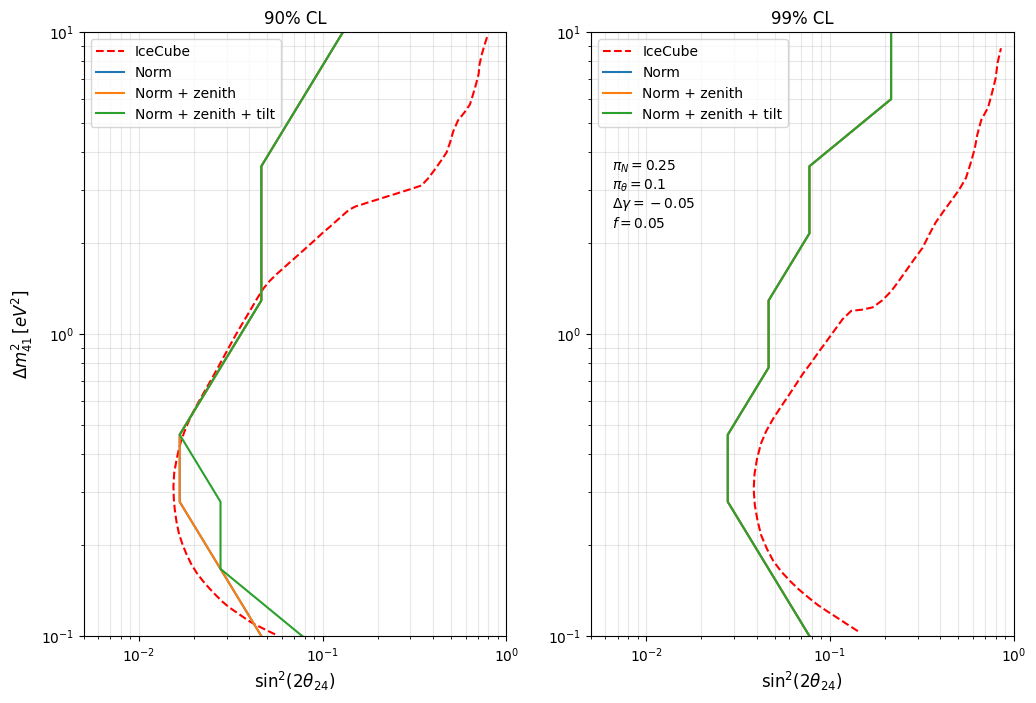

In [17]:
fig,ax = plt.subplots(1,2,figsize=(12,8))

ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube',c='red',ls='--')
ax[0].plot(s24_range[s24_cl90_index_list[0]], dm41_range[dm41_cl90_index_list[0]], label='Norm')
ax[0].plot(s24_range[s24_cl90_index_list[1]], dm41_range[dm41_cl90_index_list[1]], label='Norm + zenith')
ax[0].plot(s24_range[s24_cl90_index_list[2]], dm41_range[dm41_cl90_index_list[2]], label='Norm + zenith + tilt')

ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[1].plot(s24_range[s24_cl99_index_list[0]], dm41_range[dm41_cl99_index_list[0]], label='Norm')
ax[1].plot(s24_range[s24_cl99_index_list[1]], dm41_range[dm41_cl99_index_list[1]], label='Norm + zenith')
ax[1].plot(s24_range[s24_cl99_index_list[2]], dm41_range[dm41_cl99_index_list[2]], label='Norm + zenith + tilt')


ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1,1e1))
ax[1].set_ylim((1e-1,1e1))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[0].set_ylabel('$\\Delta m^2_{41} \, [eV^2]$', fontsize=12)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title('90% CL')
ax[1].set_title('99% CL')

ax[0].legend()
ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')

#interpolare contour mesh

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,8))
ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube (90% CL)',c='r')
ax[0].plot(s24_range[s24_cl90_index], dm41_range[dm41_cl90_index], label='My work $\\theta_{34}=0$ (90% CL)', c='green')
#ax[0].plot(s24_range[s24_cl90_index_s34], dm41_range[dm41_cl90_index_s34], label=r'My work, $\theta_{24}=\theta_{34}$ (90% CL)', c='green',ls='--')
ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube (99% CL)', ls='solid',c='r')
ax[1].plot(s24_range[s24_cl99_index_b], dm41_range[dm41_cl99_index_b], label='$\sigma_\\beta = 0.1$, no $\sigma_\gamma$', c='green')
#ax[1].plot(s24_range[s24_cl99_index], dm41_range[dm41_cl99_index], label='My work $\\theta_{34}=0$ (99% CL)', c='green', ls='solid')
#ax[1].plot(s24_range[s24_cl99_index_s34], dm41_range[dm41_cl99_index_s34], label=r'My work, $\theta_{24}=\theta_{34}$ (99% CL)', c='green', ls='--')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1,1e1))
ax[1].set_ylim((1e-1,1e1))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[0].set_ylabel('$\\Delta m^2_{41} \, [eV^2]$', fontsize=12)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title('90% CL')
ax[1].set_title('99% CL')

ax[0].legend()
ax[1].legend()

#interpolare contour mesh

NameError: name 's24_cl99_index_b' is not defined

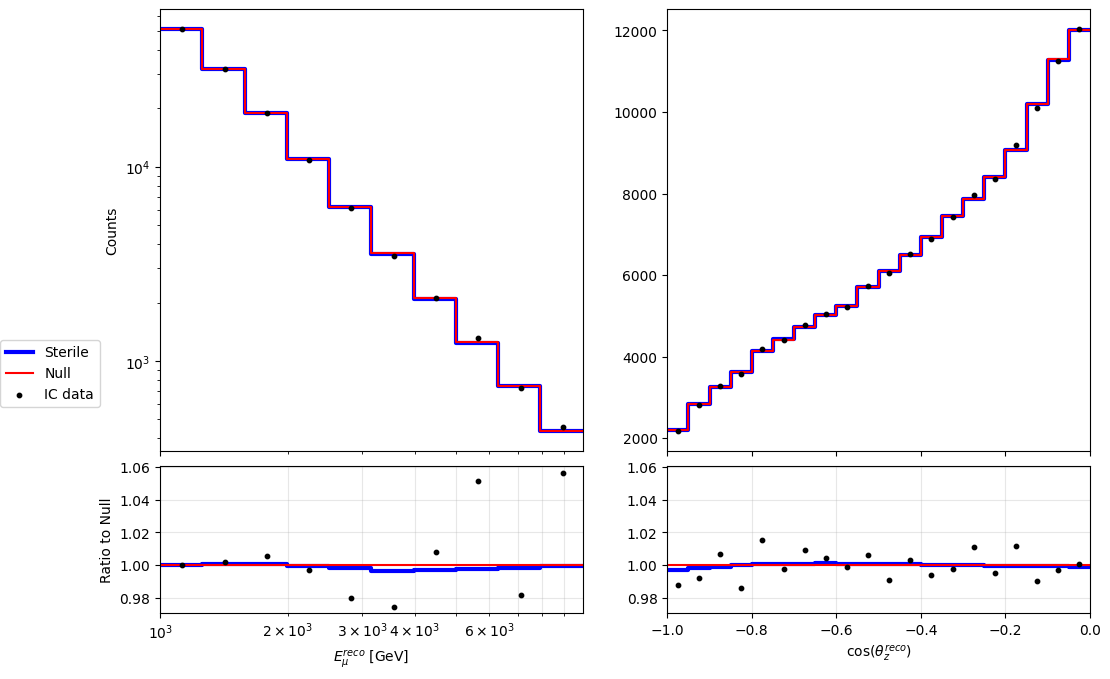

In [46]:
count_plots(H1_best,H0_normalized)

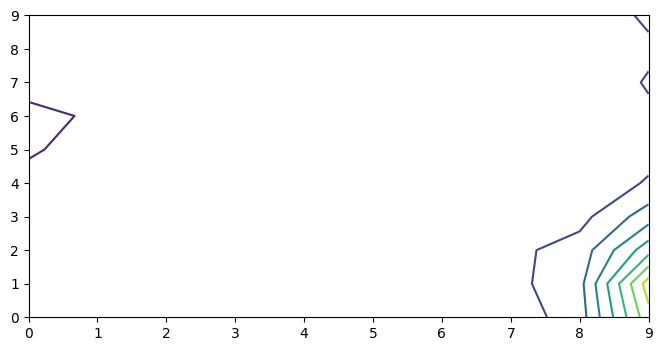

In [82]:
X,Y = np.meshgrid(dm41_range,s24_range)

fig = plt.figure()
plt.contour(deltachi_reshaped)

In [18]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
temp_params = list_of_params(ic_params, np.array([1.]), np.array([0.02,0.04,0.08]))
P = P_over_E_parameter('m', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=True)

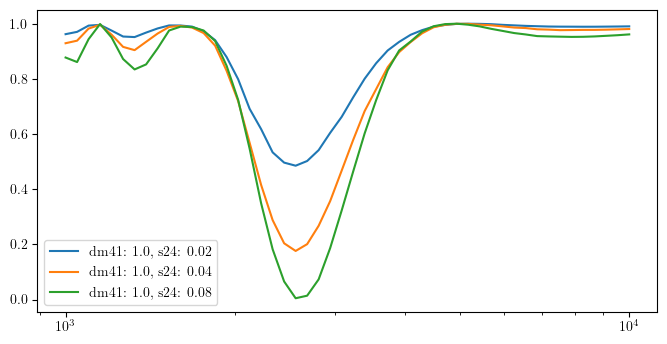

In [19]:
for i,prob in enumerate(P):
    plt.plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}')
plt.xscale('log')
plt.legend()

In [79]:
sigma_b=np.linspace(0.05,0.2,10)
sigma_a=[0.15,0.2,0.25,0.3,0.4]
d_90_index = []
s_90_index=[]
d_99_index = []
s_99_index=[]
for sa in sigma_a:
    chisq_H0, a_H0 = perform_chisq(H0_normalized,IC_observed,z=zreco[0:-1], sigma_a = sa ,sigma_b=0.05,  x0=[1,0])
    chisq_H1_list  = np.array([perform_chisq(H1_norm, IC_observed,z=zreco[0:-1], sigma_a = sa ,sigma_b=0.05, x0=[1,0])[0] for H1_norm in H1_list_normalized])
    delta_chi = chisq_H1_list - chisq_H0

    best_fit_index = np.argmin(delta_chi)
    best_fit_params = param_list[best_fit_index]
    best_fit_events = H1_list_normalized[best_fit_index]
    _, best_a =perform_chisq(best_fit_events, np.array(IC_observed),z=zreco[0:-1], sigma_a = sa ,sigma_b=0.05, x0=[1,0])
    p_value = chi2.sf(np.min(chisq_H1_list),2)
    print(delta_chi)
    if len(best_a) == 2:
        a = best_a[0]
        b = best_a[1]
        H1_best = a*(1+b*(0.5+zreco[0:-1]))*best_fit_events
    elif len(best_a) == 1:
        H1_best = a*best_fit_events


    deltachi_reshaped = delta_chi.reshape(len(dm41_range), len(s24_range))
    cl_99_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.99,df=2),True,False)
    cl_90_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.90,df=2),True,False)
    dm41_cl90_index, s24_cl90_index = get_boundary(cl_90_bool)
    dm41_cl99_index, s24_cl99_index = get_boundary(cl_99_bool)
    d_90_index.append(dm41_cl90_index)
    s_90_index.append(s24_cl90_index)
    d_99_index.append(dm41_cl99_index)
    s_99_index.append(s24_cl99_index)


[ 1.96855279e+00  4.00642768e+00  8.82914273e+00  2.09311096e+01  5.25897480e+01  1.38608770e+02  3.82665973e+02  1.12537961e+03  3.74598731e+03  1.66351595e+04  4.52422937e+00  9.66162704e+00
  2.20262220e+01  5.27315117e+01  1.29988974e+02  3.21149502e+02  7.72618378e+02  1.76479692e+03  4.17416088e+03  1.87833759e+04  5.38287223e+00  1.25178813e+01  3.00589935e+01  7.27009756e+01
  1.73080057e+02  3.99696807e+02  8.96319626e+02  1.87593447e+03  3.56315918e+03  1.15146611e+04  3.09703970e+00  8.99169002e+00  2.33160935e+01  5.29629518e+01  1.02676223e+02  1.79770133e+02
  3.90606433e+02  9.11083391e+02  1.68024927e+03  6.33622968e+03  8.39173418e-01  4.14182337e+00  1.28145445e+01  3.11320454e+01  6.09734008e+01  1.01620448e+02  1.92343575e+02  3.93669124e+02
  6.73238544e+02  2.78949171e+03 -3.31642893e-01  1.11770773e+00  5.55515769e+00  1.58623664e+01  3.41752500e+01  6.05019687e+01  1.07881703e+02  2.02047687e+02  3.45876962e+02  1.66896974e+03
 -3.93349702e-01  2.01717653e-01  2

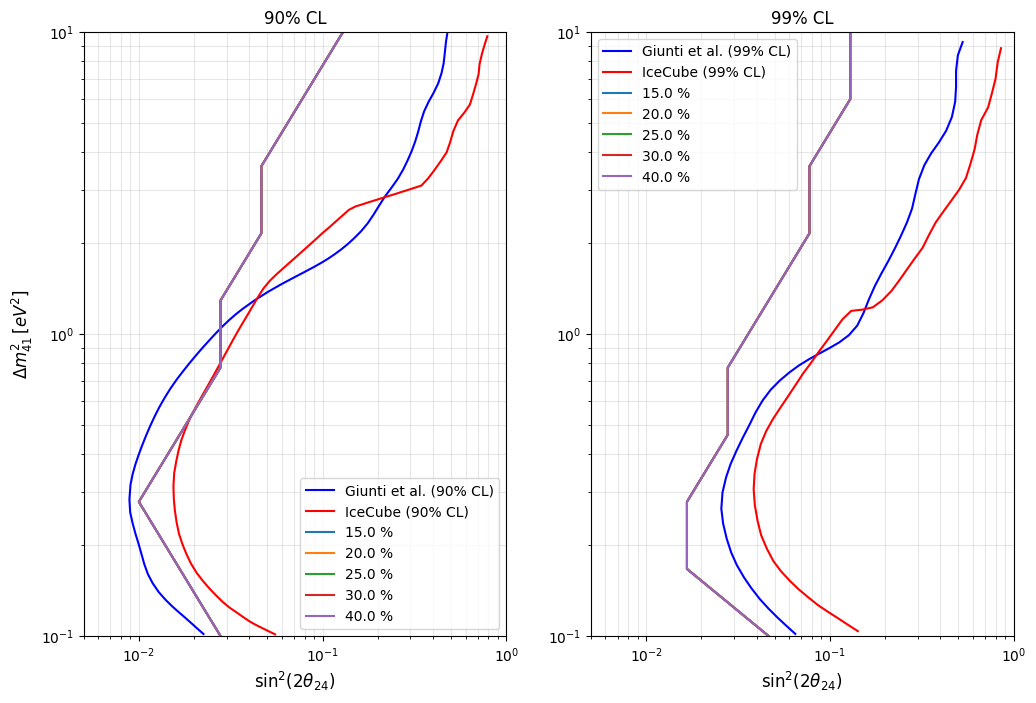

In [77]:
fig,ax = plt.subplots(1,2,figsize=(12,8))
ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube (90% CL)',c='r')

for i in range(len(sigma_a)):
    ax[0].plot(s24_range[s_90_index[i]], dm41_range[d_90_index[i]], label=f'{np.round(sigma_a[i]*100,0)} %')
#ax[0].plot(s24_range[s24_cl90_index_s34], dm41_range[dm41_cl90_index_s34], label=r'My work, $\theta_{24}=\theta_{34}$ (90% CL)', c='green',ls='--')
ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube (99% CL)', ls='solid',c='r')
for j in range(len(sigma_a)):
    ax[1].plot(s24_range[s_99_index[j]], dm41_range[d_99_index[j]], label=f'{np.round(sigma_a[j]*100,0)} %', ls='solid')
#ax[1].plot(s24_range[s24_cl99_index_s34], dm41_range[dm41_cl99_index_s34], label=r'My work, $\theta_{24}=\theta_{34}$ (99% CL)', c='green', ls='--')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1,1e1))
ax[1].set_ylim((1e-1,1e1))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[0].set_ylabel('$\\Delta m^2_{41} \, [eV^2]$', fontsize=12)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title('90% CL')
ax[1].set_title('99% CL')

ax[0].legend()
ax[1].legend()